In [1]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import numpy as np

In [2]:
seed = 1235256

width = 300

num_start_points = 17

In [3]:
key = jax.random.PRNGKey(seed)
start_xy = jax.random.randint(key, shape=(17, 2), minval=0, maxval=width)

In [4]:
jax.random.permutation(key, start_xy, independent=False)

Array([[190, 217],
       [206,  74],
       [169,  16],
       [ 50, 124],
       [155,   3],
       [223, 243],
       [211,  81],
       [180, 204],
       [191,  83],
       [ 17,  71],
       [150,  19],
       [286,  79],
       [183, 277],
       [183, 105],
       [270, 198],
       [ 62,  24],
       [240,  38]], dtype=int32)

In [5]:
# see https://github.com/google/jax/blob/main/cloud_tpu_colabs/Wave_Equation.ipynb


def axis_slice(ndim, index, axis):
    slices = [slice(None)] * ndim
    slices[axis] = index
    return tuple(slices)


def slice_along_axis(array, index, axis):
    return array[axis_slice(array.ndim, index, axis)]


def shift(array, offset, axis):
    """
    Shift the array with zero-padding.

    Args:
      offset: if positive, shift to the left; otherwise, shift to the right
    """
    index = slice(offset, None) if offset >= 0 else slice(None, offset)
    sliced = slice_along_axis(array, index, axis)
    padding = [(0, 0)] * array.ndim
    padding[axis] = (-min(offset, 0), max(offset, 0))
    return jnp.pad(sliced, padding, mode="constant", constant_values=0)

In [6]:
@jax.jit
def compute_boundary_mask(arr):
    """
    Return a mask of the boundary points.

    This will be true where a zero borders a non-zero.
    """
    mask = jnp.zeros_like(arr, dtype=bool)

    mask = mask.at[1:, :].set(jnp.logical_or(arr[:-1, :] != 0, mask[1:, :]))
    mask = mask.at[:-1, :].set(jnp.logical_or(arr[1:, :] != 0, mask[:-1, :]))
    mask = mask.at[:, 1:].set(jnp.logical_or(arr[:, :-1] != 0, mask[:, 1:]))
    mask = mask.at[:, :-1].set(jnp.logical_or(arr[:, 1:] != 0, mask[:, :-1]))

    mask = mask & (arr == 0)

    return mask


@jax.jit
def update(image, mask):
    image_xm = shift(image, -1, 0)
    image_xp = shift(image, 1, 0)
    image_ym = shift(image, -1, 1)
    image_yp = shift(image, 1, 1)

    # note that the order of updates here should be randomized
    image = jnp.where(mask & (image_xm != 0), image_xm, image)
    image = jnp.where(mask & (image_xp != 0), image_xp, image)
    image = jnp.where(mask & (image_ym != 0), image_ym, image)
    image = jnp.where(mask & (image_yp != 0), image_yp, image)

    return image


def create_image(width: int, start_xy, rand_key):
    key = rand_key

    # create an image array
    image = np.zeros((width, width), dtype=np.float32)

    # set the start points
    for tag in range(num_start_points):
        image[start_xy[tag, 0], start_xy[tag, 1]] = tag

    num_pixels = image.shape[0] * image.shape[1]

    # approx_num_iters = 100
    # pixels_per_chunk = num_pixels // approx_num_iters
    pixels_per_chunk = 100

    iter = 0
    while iter < 1000 and (num_filled := jnp.count_nonzero(image != 0)) != num_pixels:
        filled_pct = 100.0 * (num_filled / num_pixels)

        # figure out candidate points for update
        boundary_mask = compute_boundary_mask(image)
        front_x, front_y = np.nonzero(boundary_mask)
        front_xy = jnp.stack((front_x, front_y), axis=1)

        print(
            f"iter {iter:05}, len(front_xy) {len(front_xy):05}, filled_pct {filled_pct:0.3f}\r",
            end="",
            flush=True,
        )



        # randomly choose a subset to process
        front_xy = jax.random.permutation(key, front_xy)
        # TODO EDF just process in fixed chunk sizes
        # proc_index = jax.random.randint(
        #     key, shape=(1,), minval=1, maxval=len(front_xy)
        # )[0]
        proc_index = min(pixels_per_chunk, len(front_xy))
        upd_xy = front_xy[:proc_index]

        update_mask = jnp.zeros_like(image, dtype=bool)
        update_mask = update_mask.at[upd_xy[:, 0], upd_xy[:, 1]].set(True)

        image = update(image, update_mask)

        # # determine changed points
        # changed_x, changed_y = jnp.nonzero(prev_image != image)
        # changed_xy = jnp.stack((changed_x, changed_y), axis=1)



        # # add new points to the frontier
        # front_xy = jnp.concatenate((pend_xy, changed_xy), axis=0)

        iter += 1

    return image

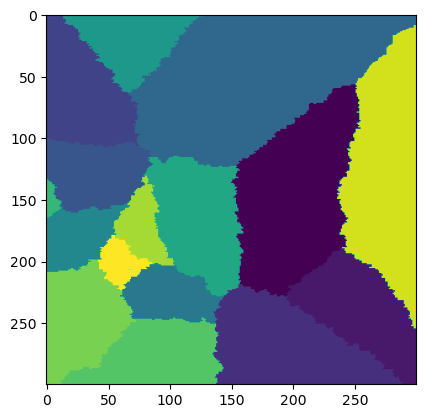

In [7]:
img = create_image(width, start_xy, key)
plt.imshow(img)

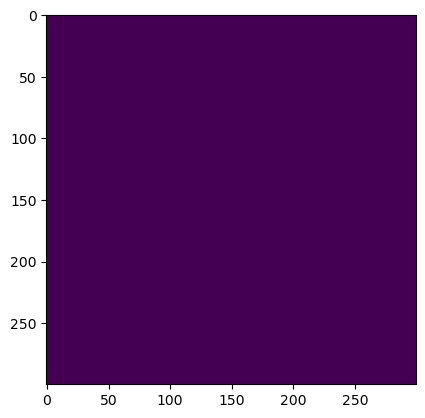

In [8]:
plt.imshow(compute_boundary_mask(img))

In [9]:
upd_x = jnp.array([1,2,3,4])
upd_y = jnp.array([5,6,7,8])

jnp.stack((upd_x, upd_y), axis=1)

Array([[1, 5],
       [2, 6],
       [3, 7],
       [4, 8]], dtype=int32)

In [10]:
image

NameError: name 'image' is not defined

In [ ]:
img = jnp.zeros((20,20))
img = img.at[7, 7].set(1)
img = img.at[7, 8].set(1)

In [ ]:
plt.imshow(img)

In [ ]:
plt.imshow(boundary_mask(img))